# Problem set 2 - Monte Carlo method & TD learning

**Due: 11:59pm, October 10, 2025**

### Problem 1 - Monte Carlo evaluation and Monte Carlo control (Coding).

TODO list:

- (1) Finish MC Policy Evaluation Code (10 pt)
- (2) Try different step size and discuss (10 pt)
- (3) Finish MC + Exploring Starts Code (10 pt)
- (4) Plot the convergence behavior, discuss the plot (10 pt)
- (5) Proof of Monte-Carlo control on *random walk* problem (20 pt)
- (6) Finish MC + epsilon greedy Code (10 pt)


<!-- - MC Policy Evaluation Code (long runtime)
- MC Policy Evaluation Different Step size plot
- MC + Exploring Starts Code (long run time)
- MC + ES Observe Plot, describe observation
- MC + ES proof 
- MC + epsilon greedy code  -->

### Problem 2 - Temporal-difference evaluation, SARSA and Q-learning
- (1) Finish TD evaluation Code (10 pt)
- (2) Finish SARSA algorithm (10 pt)
- (3) Finish Q-learning algorithm (10 pt)


<!-- - TD Evaluation
- SARSA
- Q-Learning -->


## Problem 1: Monte-Carlo method on CliffWalk environment.

Recall from last PSET, the **CliffWalking** gridworld is a 4×12 grid. The agent starts at the bottom-left cell and aims to reach the bottom-right. The bottom row between start and goal is a **cliff**; stepping into it ends the episode with a large penalty. Each non-terminal step yields −1; stepping into the cliff yields −100 (and termination).  

In this problem we will **directly use Gym/Gymnasium** to interact with the environment (`CliffWalking-v1`) and perform **Monte-Carlo (MC) method**. Here we provide the print utility function as the same in PSET 1.


In [1]:
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- Reproducibility -----
seed = 0
np.random.seed(seed)          # numpy RNG (env seeding can be done at reset time)

# ----- Environment -----
env = gym.make("CliffWalking-v1")  # 4x12 grid; bottom row is cliff + goal

# Pretty printing for small numeric tables
np.set_printoptions(precision=3, suppress=True)

def print_values(values, nrow: int, ncol: int, title: str = "State Values"):
    """
    Print a value table V in grid form.
    """
    values = np.asarray(values).reshape(nrow, ncol)
    print(title)
    for r in range(nrow):
        print(" ".join(f"{values[r, c]:6.2f}" for c in range(ncol)))
    print()

def print_policy(pi, nrow: int, ncol: int, title: str = "Policy"):
    """
    Render a policy on the CliffWalking grid as arrows.

    The environment uses the action indexing:
        0 = UP, 1 = RIGHT, 2 = DOWN, 3 = LEFT
    """
    arrow = {0: "^", 1: ">", 2: "v", 3: "<"}  # matches env action semantics
    print(title)
    for i in range(nrow):
        row_syms = []
        for j in range(ncol):
            s = i * ncol + j
            p = pi[s]

            # Determine greedy action(s)
            if isinstance(p, list) and len(p) == 4:
                best = np.argwhere(np.array(p) == np.max(p)).flatten().tolist()
            elif isinstance(p, int):
                best = [p]
            else:
                arr = np.array(p, dtype=float).ravel()
                best = np.argwhere(arr == np.max(arr)).flatten().tolist()

            # Cliff/goal cells (bottom row except column 0) rendered as terminal
            if i == nrow - 1 and j > 0:
                row_syms.append("T")
            else:
                row_syms.append("".join(arrow[a] for a in best))
        print(" ".join(sym if sym else "." for sym in row_syms))
    print()

# ----- Reference table (ground-truth under random policy from PSET1) -----
# Shape is (4, 12) in row-major order, then flattened to 1D for convenience.
# Values correspond to the state-value function V^π for the UNIFORM RANDOM policy.
V_random_gt = np.array([
    [-143.21, -147.36, -151.35, -153.93, -155.11, -155.05, -153.66, -150.44, -144.43, -134.39, -119.88, -105.06],
    [-164.99, -174.34, -180.41, -183.52, -184.80, -184.82, -183.62, -180.68, -174.67, -162.95, -141.20, -108.16],
    [-207.96, -237.09, -246.20, -249.36, -250.43, -250.52, -249.79, -247.81, -243.17, -231.62, -199.35,  -96.76],
    [-261.35,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00],
], dtype=float).flatten()


### 1.1 Monte-Carlo evaluation

Let $\mathcal{D}(s)$ denote the set of all time indices at which state $s$ is visited across sampled episodes. Then the Monte Carlo estimate of the value function is
$$
\hat{V}(s)=\frac{1}{|\mathcal{D}(s)|}\sum_{t\in \mathcal{D}(s)} g_t .
\tag{2.3}
$$

There are two common variants:

- **First-visit MC:** use only the first occurrence of $s$ in each episode.
- **Every-visit MC:** use all occurrences of $s$ within an episode.

You can test both of them in 1.2. For 1.1 you need to finish the **first-visit** one.

**TODO: Finish the code block for monte-carlo evaluation.**


MC first-visit: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


Estimated State Values (MC First-Visit)
-139.28 -147.59 -148.51 -151.14 -156.60 -151.77 -152.51 -154.37 -147.23 -140.54 -123.82 -110.42
-164.94 -175.27 -177.46 -184.95 -186.62 -183.17 -178.03 -180.75 -176.37 -168.28 -143.55 -112.00
-202.03 -235.31 -248.53 -250.06 -248.80 -247.99 -246.18 -242.22 -237.27 -234.91 -201.70 -98.62
-260.12   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



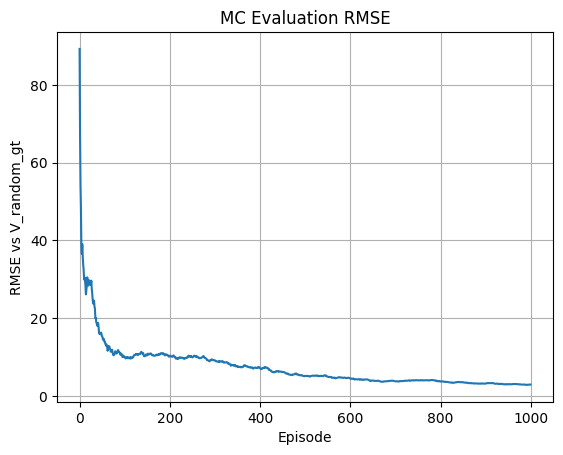

In [2]:
def mc_evaluate(policy, env, episodes=5000, gamma=0.95, seed=None):
    """
    First-visit Monte Carlo (MC) state-value prediction (Sutton & Barto, Alg. 5.1).

    Parameters
    ----------
    policy : ndarray, shape (nS, nA)
        Row-stochastic policy: for each state s, policy[s] is a prob. dist. over actions.
    env : Gymnasium-like environment
        Must expose discrete observation_space.n and action_space.n and return
        (obs, reward, terminated, truncated, info) from step().
    episodes : int
        Number of episodes to sample.
    gamma : float
        Discount factor in [0, 1].
    seed : int | None
        If given, used to seed a NumPy RNG and (re)seed env at each episode start.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)          # value estimates
    N_first = np.zeros(nS, dtype=int)      # first-visit counts per state
    visits = np.zeros(nS, dtype=int)       # total visits (diagnostic only)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc="MC first-visit"):
        # Episode generation under π
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            a = np.random.choice(np.arange(nA), p=policy[s])
            new_s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            states.append(s)
            rewards.append(r)
            s = new_s
            ##########################################

        # Identify first visits of each state in this episode
        first_visit_mask = [False] * len(states)
        seen_from_start = set()
        for t, st in enumerate(states):
            if st not in seen_from_start:
                seen_from_start.add(st)
                first_visit_mask[t] = True

        # Backward return accumulation; update ONLY on first visits
        ##########################################
        # TODO: update V and N_first for first-visit states
        G = 0.0
        for t in reversed(range(len(states))):
            s = states[t]
            r = rewards[t]
            G = r + gamma * G
            visits[s] += 1
            if first_visit_mask[t]:
                N_first[s] += 1
                V[s] += (G - V[s]) / N_first[s]  # Incremental mean update
        ##########################################

        # Track RMSE to a reference table for the random policy (from PSET1)
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors


# Uniform-random policy for evaluation
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V, errors = mc_evaluate(policy, env, episodes=1000)

print_values(V, 4, 12, "Estimated State Values (MC First-Visit)")
# Compare visually with PSET1 reference; they should be close (up to sampling noise).

plt.figure()
plt.plot(errors)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation RMSE")
plt.grid(True)
plt.show()

# Note: On my laptop this may take ~1 minute for 1k episodes, depending on Python + Gym versions.

### 1.2 Plot for different step size.

Recall equation (2.4) in the lecture note:
$$
\hat{V}(s) \leftarrow \hat{V}(s) + \alpha_{N(s)}\!\left(g_t - \hat{V}(s)\right),
\qquad \alpha_{N(s)} > 0 \text{ diminishing.}
$$

For standard Monte-Carlo evaluation, you will take the $\alpha_{N(s)}$ as $\frac{1}{N(s)}$. But you have more options: you can do constant step or other steps you prefer.

**TODO: test different step size options (sample average, constant step size with different values, and another step size schedule that satisfies Robbins-Monro), and you can also change first-visit to every-visit. What do you observe?**

Hint: you can try save different loss curves and plot in the same plot

MC (every, schedule): 100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s]


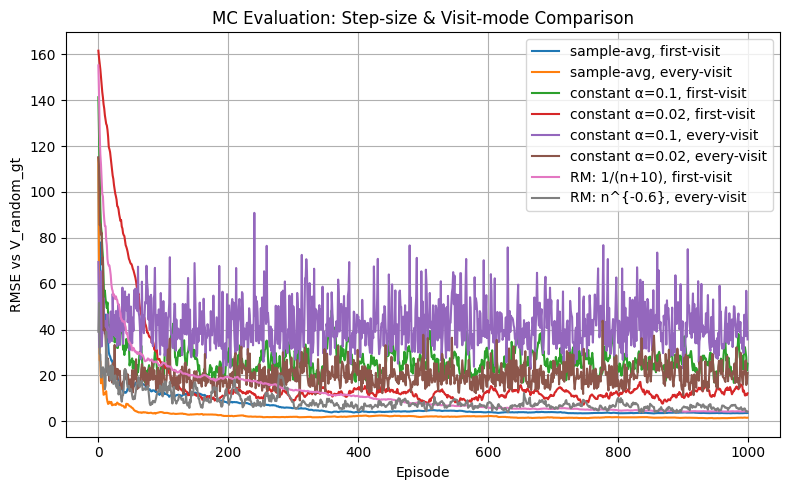

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def mc_evaluate_flexible(
    policy,
    env,
    episodes=5000,
    gamma=0.95,
    seed=None,
    visit_mode="first",          # "first" or "every"
    step_type="sample_average",  # "sample_average" | "constant" | "schedule"
    alpha=0.1,                   # constant step size (used when step_type="constant")
    schedule_fn=None,            # step size schedule function, e.g., schedule_fn(n_visits) -> alpha_n
    V_init=None,                 # optional: custom initial V
    V_ref=None                   # optional: reference table for RMSE (default uses global V_random_gt)
):
    """
    first/every-visit Monte Carlo (MC) state-value prediction with flexible step-size.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float) if V_init is None else np.array(V_init, dtype=float)
    errors = []

    N_updates = np.zeros(nS, dtype=int)

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc=f"MC ({visit_mode}, {step_type})"):
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            a = np.random.choice(np.arange(nA), p=policy[s])
            new_s, r, terminated, truncated, _ = env.step(a)
            states.append(s)
            rewards.append(r)
            s = new_s
            done = terminated or truncated

        # 标记 first-visit
        first_visit_mask = [False] * len(states)
        if visit_mode == "first":
            seen = set()
            for t, st in enumerate(states):
                if st not in seen:
                    seen.add(st)
                    first_visit_mask[t] = True
        else:
            # every-visit mode: all True
            first_visit_mask = [True] * len(states)

        # Backward return accumulation and update according to chosen step-size
        G = 0.0
        for t in reversed(range(len(states))):
            s_t = states[t]
            r_t = rewards[t]
            G = r_t + gamma * G

            if first_visit_mask[t]:
                N_updates[s_t] += 1

                # choose step size
                if step_type == "sample_average":
                    # α_n = 1 / N(s) (Robbins-Monro condition satisfied)
                    alpha_t = 1.0 / N_updates[s_t]

                elif step_type == "constant":
                    # constant step-size (does not satisfy RM, but common in non-stationary or control problems)
                    alpha_t = float(alpha)

                elif step_type == "schedule":
                    # custom schedule (satisfying Robbins-Monro, e.g., 1 / (n + c) or n^-p, 0.5<p<=1)
                    if schedule_fn is None:
                        # default safe RM-type schedule: alpha_n = 1 / (n + c)
                        c = 10.0
                        alpha_t = 1.0 / (N_updates[s_t] + c)
                    else:
                        alpha_t = float(schedule_fn(N_updates[s_t]))
                else:
                    raise ValueError(f"Unknown step_type: {step_type}")

                V[s_t] += alpha_t * (G - V[s_t])

        ref = V_random_gt if V_ref is None else V_ref
        rmse = float(np.sqrt(np.mean((V - ref) ** 2)))
        errors.append(rmse)

    return V, errors


# ---------- Plot on one figure ----------
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

experiments = []

# 1) sample-average (first-visit)
V_sa_fv, err_sa_fv = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="first",
    step_type="sample_average",
)
experiments.append(("sample-avg, first-visit", err_sa_fv))

# 2) sample-average (every-visit)
V_sa_ev, err_sa_ev = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="every",
    step_type="sample_average",
)
experiments.append(("sample-avg, every-visit", err_sa_ev))

# 3) constant step-size α=0.1 (first-visit)
V_c01_fv, err_c01_fv = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="first",
    step_type="constant",
    alpha=0.1
)
experiments.append(("constant α=0.1, first-visit", err_c01_fv))

# 4) constant step-size α=0.02 (first-visit)
V_c002_fv, err_c002_fv = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="first",
    step_type="constant",
    alpha=0.02
)
experiments.append(("constant α=0.02, first-visit", err_c002_fv))

# 5) constant step-size α=0.1 (every-visit)
V_c01_ev, err_c01_ev = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="every",
    step_type="constant",
    alpha=0.1
)
experiments.append(("constant α=0.1, every-visit", err_c01_ev))

# 6) constant step-size α=0.02 (every-visit)
V_c002_ev, err_c002_ev = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="every",
    step_type="constant",
    alpha=0.02
)
experiments.append(("constant α=0.02, every-visit", err_c002_ev))

# 7) Robbins-Monro schedule: alpha_n = 1 / (n + c), c=10 (first-visit)
def rm_schedule(n):
    c = 10.0
    return 1.0 / (n + c)

V_sched_fv, err_sched_fv = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="first",
    step_type="schedule",
    schedule_fn=rm_schedule
)
experiments.append(("RM: 1/(n+10), first-visit", err_sched_fv))

# 8) Robbins-Monro schedule: alpha_n = n^{-0.6} (every-visit)
def power_schedule(n):
    # n >= 1 for meaningful results; here n is the update count starting from 1
    p = 0.6  # 0.5 < p <= 1 satisfies RM condition
    return 1.0 / (max(1, n) ** p)

V_sched_ev, err_sched_ev = mc_evaluate_flexible(
    policy, env,
    episodes=1000, gamma=0.95, seed=42,
    visit_mode="every",
    step_type="schedule",
    schedule_fn=power_schedule
)
experiments.append((r"RM: n^{-0.6}, every-visit", err_sched_ev))

# -------------------- Plot --------------------
plt.figure(figsize=(8, 5))
for label, errs in experiments:
    plt.plot(errs, label=label)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation: Step-size & Visit-mode Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



**Answer:**

From the plot, every-visit variants consistently learn faster than first-visit early on. Constant step sizes give quick initial drop but settle with a higher, noisier error floor (especially with a larger $\alpha$), showing clear variance spikes. Sample-average ($\alpha=\frac{1}{N(s)}$) is the most stable and attains the lowest long-run error. The Robbins–Monro schedules sit in between: they keep much lower variance than constant $\alpha$, and achieve stability-speed trade-offs overall.


### 1.3 Monte-Carlo control with Exploring Starts

In the class we talk about two methods to ensure exploration: exploring starts and $\epsilon$-greedy policy. We will start with exploring starts for monte-carlo control.

**TODO: finish code of Monte-Carlo control with exploring starts**.

In [ ]:
def _set_state(env, s):
    """Attempt to set the environment's internal discrete state to `s`
    (needed for Exploring Starts).
    """
    try:
        # Many classic-control/grid envs expose `unwrapped.s`
        env.unwrapped.s = s
        return True
    except Exception:
        # Some variants use `.state` instead
        try:
            env.unwrapped.state = s
            return True
        except Exception:
            return False


def mc_control_exploring_starts(env, episodes=5000, gamma=0.95, max_steps=500, alpha=None):
    """
    Monte Carlo control with Exploring Starts (ES).  See Sutton & Barto, Alg. 5.3.

    Procedure
    ---------
    1) For each episode, sample an initial state–action pair (S0, A0) at random so that
       every (s, a) has nonzero probability.
    2) Roll out the *entire* episode under the current policy π (use A0 at t=0; thereafter
       sample actions from π).
    3) At the end of the episode, perform **first-visit** MC updates to Q(s, a) using the
       return G from each first-visited (s, a).
    4) For all states visited in this episode, improve the policy greedily:
       π(s) ← argmax_a Q(s, a) (break ties uniformly).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    N_visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    # Initialize π arbitrarily: start with a uniform distribution over actions.
    policy = np.ones((nS, nA), dtype=float) / nA

    for ep in tqdm(range(episodes), desc="MC ES (Exploring Starts)"):
        # --- Exploring Start: choose (S0, A0) uniformly at random ---
        # For CliffWalking we avoid terminal/cliff cells by excluding the last row
        # except the start (index 36). `nS - 11` ensures s0 ∈ {0..36}.
        s0 = np.random.randint(nS - 11)
        a0 = np.random.randint(nA)

        # Reset env, then force the start state to s0. If not supported, ES cannot be run strictly.
        s, _ = env.reset()
        if not _set_state(env, s0):
            raise RuntimeError(
                "Environment does not support setting arbitrary start states; "
                "strict Exploring Starts is not possible."
            )

        # --- Generate a full trajectory under current π (A0 at t=0, then follow π) ---
        states, actions, rewards = [], [], []
        s = s0
        a = a0
        done = False

        # Cap length to avoid pathological loops when π does not reach a terminal.
        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            new_s, r, terminated, truncated, info = env.step(a)
            states.append(s)
            actions.append(a)
            rewards.append(r)
            s = new_s
            done = terminated or truncated
            if done:
                break
            # After the first step, sample actions from the current policy
            a = np.random.choice(np.arange(nA), p=policy[s])

            ##########################################

        # --- First-visit masks for (s, a) within this episode ---
        first_visit_sa_mask = [False] * len(states)
        seen_from_start_sa = set()
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen_from_start_sa:
                seen_from_start_sa.add((st, at))
                first_visit_sa_mask[t] = True

        # --- Backward return accumulation; update Q only at first visits ---
        ##########################################
        # TODO: update Q and N_first for first-visit states
        G = 0.0
        for t in reversed(range(len(states))):
            s_t = states[t]
            a_t = actions[t]
            r_t = rewards[t]
            G = r_t + gamma * G
            if first_visit_sa_mask[t]:
                N_visits[s_t, a_t] += 1
                if alpha is None:
                    # sample-average update
                    Q[s_t, a_t] += (G - Q[s_t, a_t]) / N_visits[s_t, a_t]
                else:
                    # constant step-size update
                    Q[s_t, a_t] += alpha * (G - Q[s_t, a_t])

        ##########################################

        # --- Greedy policy improvement on states encountered this episode (uniform tie-breaking) ---
        ##########################################
        # TODO: update policy to be greedy wrt. Q for states visited in this episode
        visited_states = set(states)
        for s in visited_states:
            best_a = np.argwhere(Q[s] == np.max(Q[s])).flatten().tolist()
            # tie-break uniformly among best actions
            new_action_probs = np.zeros(nA, dtype=float)
            for a in best_a:
                new_action_probs[a] = 1.0 / len(best_a)
            policy[s] = new_action_probs
        ##########################################

        # Keep a few early snapshots of V(s) for quick diagnostics
        if (ep % 100) == 0 and ep <= 10000:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


policy_es, Q_es, V_snaps = mc_control_exploring_starts(env, episodes=200000, gamma=0.95)

V_es = (policy_es * Q_es).sum(axis=1)
print_values(V_es, 4, 12, "V from MC-ES policy")
print_policy(policy_es, 4, 12, "MC-ES derived policy")

# Note: With 200k episodes this can take around a minute on a typical laptop
# (depends on Python/Gym versions and hardware).


MC ES (Exploring Starts): 100%|██████████| 200000/200000 [00:57<00:00, 3481.47it/s]

V from MC-ES policy
-10.26  -9.78  -9.21  -8.63  -8.06  -7.42  -6.74  -6.04  -5.30  -4.53  -3.72  -2.86
 -9.92  -9.24  -8.64  -8.03  -7.41  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95
-10.47  -9.65  -9.10  -7.74  -6.99  -6.16  -5.36  -4.54  -3.73  -2.86  -1.95  -1.00
-10.92   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC-ES derived policy
> > > v v > > v > v v v
> > > > > > > > > > > v
> > > > > > > > > > > v
^ T T T T T T T T T T T



### 1.4 Convergence behavior

Use the `V_snap` you get from Monte-Carlo control to plot the convergence evolution.

**TODO: what do you observe form the plot?**

Hint: which part converge first?

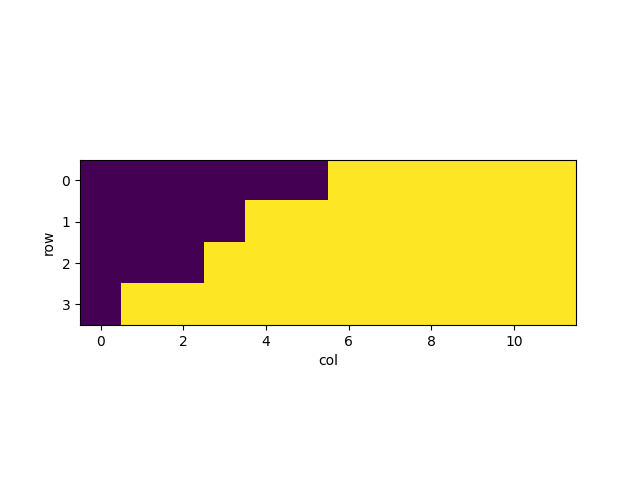

Saved GIF to: ./mc_es_grid_evolution.gif


In [8]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Basic check
V_snaps = [np.asarray(v).ravel() for v in V_snaps]
K = int(V_snaps[0].size)
if K != 48:
    raise ValueError(f"Expected V.size == 48 to reshape into 4x12, but got {K}.")

# Fixed color scale to avoid per-frame jumps (do not specify a colormap; use defaults)
V_all = np.vstack(V_snaps)
vmin, vmax = -20, 0

# Initialize figure: 2D grid
fig, ax = plt.subplots()
grid0 = V_snaps[0].reshape(4, 12)
im = ax.imshow(grid0, vmin=vmin, vmax=vmax)  # Do not specify cmap
ax.set_xlabel("col")
ax.set_ylabel("row")

def init():
    im.set_data(grid0)
    return (im,)  # blit requires a tuple

def update(i):
    grid = V_snaps[i].reshape(4, 12)
    im.set_data(grid)
    return (im,)

ani = animation.FuncAnimation(
    fig, update, frames=len(V_snaps), init_func=init, blit=True, interval=400, repeat=False
)

gif_path = "./mc_es_grid_evolution.gif"
ani.save(gif_path, writer="pillow")
plt.close(fig)

display(Image(filename=gif_path))
print("Saved GIF to:", gif_path)

# Print the last frame as a 4x12 grid
V_last = V_snaps[-1].reshape(4, 12)
np.set_printoptions(precision=2, suppress=True)  # Pretty printing

**Answer:**

In the convergence animation, values near the goal stabilize first, especially along the safe corridor that the improving policy learns to follow. As the policy concentrates probability mass on this route, the mid-path states converge next thanks to higher visitation and lower return variance. States far from the goal(particularly around the start) converge last because their returns depend on long, noisy rollouts. Cells adjacent to the cliff also settle more slowly early on due to policy oscillation between exploration and avoidance. Conversely, actions that step into the cliff become confidently poor very quickly (large negative returns), so their Q-values drop fast and are pruned by the greedy updates.


### 1.5 Random walk on a ring: Why can monte-carlo method works? (Pen and Paper)

In this problem you will use a random walk problem to analyze the convergence behavior of Monte-Carlo control.

Consider a 1-D random walk problem on a ring, and one of them is the terminal state. Assume states are $\{0,1,2,...,K - 1\}$, and $0$ is the terminal state. The transition model can be written as $x_{k+1} = \text{mod}(x_k + u_k)$ where $u_k = -1 / 1$.

**Setup.**  
States $ \mathcal S=\{0,1,\dots,K-1\} $ with terminal $0$ (absorbing).  
Actions $ \mathcal A=\{-1,+1\} $, transition $ s'=(s+a)\bmod K $ (Note that terminal is absorb, so once it arrive $0$ it will not move).  
Per-step reward $-1$ until termination; discount $ \gamma\in(0,1] $.  
Distance to $0$: $ d(s)=\min\{s,K-s\} $.  
Algorithm: first-visit Monte-Carlo control with **Exploring Starts**.

**Claim.** With probability $1$, the learned policy converges to
$$
\pi^\star(s)=
\begin{cases}
\text{move to reduce } d(s), & d(s)\neq K/2,\\
\text{either action}, & d(s)=K/2 \text{ (if $K$ even),}
\end{cases}
$$
i.e., “go along the shortest arc to $0$”.

### Proof (outward induction on $d$)

First we write down the optimal value $V^\star$ under $\pi^\star$


**(a) TODO: write down $V^\star$** 

**Answer:**

$V^\star(0)=0$.
For $s\neq 0$:
* When $\gamma\in(0,1)$, 
$$
V^\star(s)=\sum_{t=0}^{d(s)-1}\gamma^t\cdot (-1) = -\frac{1-\gamma^{d(s)}}{1-\gamma}
$$
* When $\gamma=1$, 
$$V^\star(s)=\sum_{t=0}^{d(s)-1} (-1)=-d(s)$$

Notice that $V^\star(0)=0$ also satisfies the equation when $s\neq 0$. So 
$$
V^\star(s)=
\begin{cases}
-\frac{1-\gamma^{d(s)}}{1-\gamma}, & \gamma \in (0,1),\\
-d(s), & \gamma =1,
\end{cases}
$$
**Base of induction ($d=0$).** 

**(b) TODO: Show that $Q(0,a)\equiv 0$** 

**Answer:** 

0 is the absorbing terminal state, so once you achieve state 0, you will not get rewards afterwards. So if you start at $s=0$, no matter what action you take, the sum of rewards will always be 0, so we have:
$$
Q(0,a)\equiv 0, \quad \forall a\in \{-1,+1\}
$$



**Inductive hypothesis.** For every state with $d\le m-1$, the maximization of $Q(s,a)$ is already optimal, i.e.
$$
\max_a Q(s,a) := V(s) = V^\star
$$

**(c) TODO: For $d(s)=m$, show that $Q(s,\text{toward}) \geq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$)** 

**Answer:** 

* If $m=K/2$, then $Q(s,\text{toward})=K/2-1$, $Q(s,\text{away})=K/2-1$, so $Q(s,\text{toward}) = Q(s,\text{away})$.
* If $m\neq K/2$, 
$$
Q(s,\text{toward})=-1+\gamma V^{\star}(s'_{toward}),
$$
$$
Q(s,\text{away})=-1+\gamma V^{star}(s'_{away})
$$
When $\gamma\in (0,1)$, 
$$
Q(s,\text{toward})-Q(s,\text{away})=\gamma(-\frac{1-\gamma^{m-1}}{1-\gamma}+\frac{1-\gamma^{m+1}}{1-\gamma})=\gamma\cdot\frac{\gamma^{m-1}-\gamma^{m+1}}{1-\gamma}=\gamma^m(1+\gamma)>0
$$
Thus
$$
Q(s,\text{toward})>Q(s,\text{away})
$$
When $\gamma=1$
$$
Q(s,\text{toward})=-1-(m-1)=-m
$$
$$
Q(s,\text{away})=-1-(m+1)=-m-2
$$
So
$$
Q(s,\text{toward})>Q(s,\text{away})
$$
So we have $Q(s,\text{toward}) \geq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$) at $d(s)=m$.

//

Therefore greedy improvement sets $\pi(s)=\text{toward}$. By convergence of monte-carlo evaluation under fix policy, $Q(s,\text{toward})$ finally converge.

### 1.6 Monte-Carlo control with $\epsilon$-soft policies

**TODO: finish the code for Monte-Carlo control with $\epsilon$-soft policies** 

In [ ]:
def _epsilon_soft_from_Q(Q_row: np.ndarray, epsilon: float, tol: float = 1e-12) -> np.ndarray:
    """
    Build an ε-soft *greedy* action distribution from a vector of Q-values.

    Rule:
      1) Give every action a base mass ε/|A|.
      2) Split the remaining (1-ε) uniformly among the greedy (argmax) actions.
         (Deterministic tie-handling: no random tie-breaking.)
    """
    nA = Q_row.shape[0]
    probs = np.full(nA, epsilon / nA, dtype=float)

    m = Q_row.max()
    ties = np.flatnonzero(np.isclose(Q_row, m, atol=tol, rtol=0.0))
    share = (1.0 - epsilon) / ties.size
    probs[ties] += share
    return probs


def mc_control_onpolicy_epsilon_soft(
    env,
    episodes: int = 5000,
    gamma: float = 0.95,
    max_steps: int = 500,
    alpha: float | None = None,   # None → sample mean 1/N(s,a); else constant step-size
    epsilon: float = 0.1,         # constant ε if no schedule is provided
    eps_schedule=None,            # optional callable: eps = eps_schedule(ep)  (GLIE-style)
    min_epsilon: float = 0.0,
):
    """
    On-policy first-visit Monte Carlo control with ε-soft policies
    (Sutton & Barto, On-policy MC Control).

    Key differences from MC with Exploring Starts (ES):
      • No exploring starts; episodes are generated by the current ε-soft policy π.
      • Policy improvement *keeps* π ε-soft: greedy actions get (1-ε)+ε/|A|, others ε/|A|.
    """
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA), dtype=float)
    N_first = np.zeros((nS, nA), dtype=int)

    # Initialize π arbitrarily: uniform over actions (already ε-soft for any ε).
    policy = np.full((nS, nA), 1.0 / nA, dtype=float)

    ep_idx, V_snaps = [], []

    for ep in tqdm(range(episodes), desc="MC (ε-soft)"):
        # GLIE-style ε schedule (optional)
        eps = float(eps_schedule(ep)) if eps_schedule is not None else float(epsilon)
        eps = float(np.clip(eps, min_epsilon, 1.0))

        # ---- Generate one episode under current ε-soft policy π ----
        states, actions, rewards = [], [], []
        s, _ = env.reset()
        a = int(np.random.choice(nA, p=policy[s]))  # first action from current policy

        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            new_s, r, terminated, truncated, info = env.step(a)
            states.append(s)
            actions.append(a)
            rewards.append(r)
            s = new_s
            done = terminated or truncated
            if done:
                break
            a = np.random.choice(np.arange(nA), p=policy[s])
            ##########################################

        # ---- First-visit markers for (s,a) within this episode ----
        seen = set()
        first_visit = [False] * len(states)
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen:
                seen.add((st, at))
                first_visit[t] = True

        # ---- Backward return accumulation; update Q only at first visits ----
        ##########################################
        # TODO: update Q and N_first for first-visit states
        G = 0.0
        for t in reversed(range(len(states))):
            s_t = states[t]
            a_t = actions[t]
            r_t = rewards[t]
            G = r_t + gamma * G
            if first_visit[t]:
                N_first[s_t, a_t] += 1
                if alpha is None:
                    # sample-average update
                    Q[s_t, a_t] += (G - Q[s_t, a_t]) / N_first[s_t, a_t]
                else:
                    # constant step-size update
                    Q[s_t, a_t] += alpha * (G - Q[s_t, a_t])
        ##########################################

        # ---- ε-soft greedy policy improvement (only on states seen this episode) ----
        visited_states = set(states)
        for st in visited_states:
            policy[st] = _epsilon_soft_from_Q(Q[st], eps)

        # Light snapshots for convergence plots (every 100 eps)
        if (ep % 100) == 0:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


def eps_schedule(ep, c=2000.0, eps_min=0.01):
    """Simple GLIE schedule: ε_ep = max(eps_min, c / (c + ep))."""
    return max(eps_min, c / (c + ep))


policy, Q, V_snaps = mc_control_onpolicy_epsilon_soft(
    env,
    episodes=10000,
    gamma=0.95,
    epsilon=1.0,  # start fully exploratory; schedule will decay it
    eps_schedule=lambda ep: eps_schedule(ep, c=2000.0, eps_min=0.01),
    min_epsilon=0.0,
    alpha=0.01    # constant step-size for Q-updates (try None for 1/N(s,a))
)

V_soft = (policy * Q).sum(axis=1)
print_values(V_soft, 4, 12, "V from MC ε-soft policy")
print_policy(policy, 4, 12, "MC ε-soft derived policy")


MC (ε-soft): 100%|██████████| 10000/10000 [00:13<00:00, 759.69it/s]

V from MC ε-soft policy
-12.52 -11.70 -11.12 -10.56  -9.82  -9.19  -8.42  -7.58  -6.70  -5.80  -4.82  -4.00
-12.76 -12.39 -13.24 -13.87 -13.64 -12.70 -12.51 -11.30 -10.27  -8.32  -4.15  -2.85
-13.74 -20.09 -31.45 -36.85 -41.03 -41.61 -40.01 -40.46 -36.47 -25.17 -10.59  -1.47
-18.94   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC ε-soft derived policy
> > > > > > > > > > > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ T T T T T T T T T T T



## Problem 2: SARSA & Q-learning on Cliffwalk environment

### 2.1 TD evaluation

**Algorithmic Form.** Suppose the agent is in state $s_t$, takes action $a_t \sim \pi(\cdot \mid s_t)$, receives reward $r_t$, and transitions to $s_{t+1}$. The TD(0) update rule is
$$
\hat V(s_t) \leftarrow \hat V(s_t) + \alpha\,[\,r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t)\,],
\tag{2.6}
$$
where $\alpha \in (0,1]$ is the learning rate.

The term inside the brackets,
$$
\delta_t = r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t),
\tag{2.7}
$$
is called the **TD error**.

**TODO: finish the code for TD evluation**

TD evaluation: 100%|██████████| 1000/1000 [01:43<00:00,  9.65it/s]

Estimated State Values (TD(0) evaluation)
-142.22 -146.22 -148.42 -150.19 -152.53 -153.22 -151.65 -147.26 -140.01 -131.72 -116.18 -101.72
-163.61 -173.78 -176.17 -183.23 -183.03 -191.10 -184.13 -181.24 -168.23 -156.31 -137.65 -105.86
-206.84 -249.85 -243.72 -246.52 -248.35 -252.15 -248.40 -239.37 -235.93 -221.72 -184.42 -93.70
-258.69   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



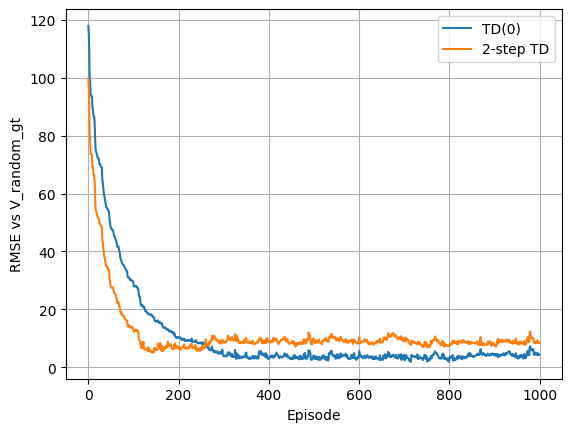

In [12]:
def td0_evaluate(env, episodes=5000, gamma=0.95, alpha=0.1, seed=None):
    """
    On-policy temporal-difference evaluation under a **uniform random policy**.

    Computes:
      • V_TD0 : TD(0) / 1-step bootstrap   V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
      • V_TD2 : 2-step TD for the *previous* state s_{t-1}
                V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
                (This is the n=2 special case of n-step TD.)
    Returns V_TD0 and RMSE traces for both estimators vs the provided V_random_gt.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    policy = np.ones((nS, nA)) / nA

    V_TD0 = np.zeros(nS, dtype=float)
    V_TD2 = np.zeros(nS, dtype=float)

    visit_counts = np.zeros(nS, dtype=int)  # diagnostic only
    errors_1, errors_2 = [], []

    if seed is not None:
        np.random.seed(seed)

    for _ in tqdm(range(episodes), desc="TD evaluation"):
        s, _ = env.reset()
        done = False

        # Keep the previous transition to form a 2-step target
        prev_state = None      # will hold s_{t-1}
        prev_reward = None     # will hold r_{t-1}

        while not done:
            ##########################################
            # TODO: step the environment, update Q
            a = np.random.choice(np.arange(nA), p=policy[s])
            new_s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            visit_counts[s] += 1
            # TD(0) update for current state s_t
            V_TD0[s] += alpha * (r + gamma * V_TD0[new_s] - V_TD0[s])
            # 2-step TD update for previous state s_{t-1}
            if prev_state is not None and prev_reward is not None:
                V_TD2[prev_state] += alpha * (prev_reward + gamma * r + gamma**2 * V_TD2[new_s] - V_TD2[prev_state])

            prev_state = s
            prev_reward = r
            s = new_s
            ##########################################

        # Episode-level RMSE diagnostics
        errors_1.append(np.sqrt(np.mean((V_TD0 - V_random_gt) ** 2)))
        errors_2.append(np.sqrt(np.mean((V_TD2 - V_random_gt) ** 2)))

    return V_TD0, (errors_1, errors_2)


# Example run
V, (errors_1, errors_2) = td0_evaluate(env, episodes=1000, alpha=0.01)

print_values(V, 4, 12, "Estimated State Values (TD(0) evaluation)")

plt.figure()
plt.plot(errors_1, label="TD(0)")
plt.plot(errors_2, label="2-step TD")
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.grid(True)
plt.legend()
plt.show()

# Note: On my laptop this may take ~20s for 1k episodes


### 2.2 SARSA algorithm

In [13]:
def sarsa(
    env,
    episodes=5000,
    Q_init=None,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    On-policy SARSA(0) control for **tabular, discrete** Gymnasium environments.

    Behavior policy: ε-greedy w.r.t. current Q.
    Update rule (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ Q(s', a') − Q(s,a) ],
    where a' is sampled ε-greedily from state s' (on-policy).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = Q_init.copy() if Q_init is not None else np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: uniform random with prob ε; otherwise greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="SARSA control"):
        s, _ = env.reset()
        a = eps_greedy_action(s, epsilon)

        # (Optional) record of visited states; useful for debugging/plots.
        s_record = []

        for _ in range(max_steps):
            ##########################################
            # TODO: step the environment, update Q and choose action
            new_s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            visits[s, a] += 1
            new_a = eps_greedy_action(new_s, epsilon)
            Q[s, a] += alpha * (r + gamma * Q[new_s, new_a] - Q[s, a])
            s_record.append(s)
            if done:
                break
            s = new_s
            a = new_a
            ##########################################

        # Lightweight snapshots early on (every 2 episodes up to 100)
        if (ep % 2) == 0 and ep <= 100:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, visits, V_snaps


Q, visits, V_snaps = sarsa(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after SARSA)")


SARSA control: 100%|██████████| 50000/50000 [00:15<00:00, 3311.72it/s]

State Values (greedy after SARSA)
 -9.50  -9.13  -8.68  -8.19  -7.66  -7.09  -6.49  -5.85  -5.17  -4.45  -3.68  -2.86
 -9.77  -9.22  -8.66  -8.05  -7.42  -6.76  -6.05  -5.32  -4.54  -3.72  -2.86  -1.96
-10.28  -9.55  -8.80  -7.89  -7.55  -6.53  -6.01  -4.82  -3.78  -2.87  -1.95  -1.00
-10.77   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



### 2.3 Q-learning algorithm

In [14]:
def q_learning(
    env,
    episodes=20000,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    Tabular **Q-learning** (off-policy, 1-step TD) control.

    Behavior policy: ε-greedy w.r.t. current Q (for exploration).
    Target policy:   greedy (max over actions in s')  — this is what makes it **off-policy**.

    Update (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ * max_{a'} Q(s', a') − Q(s,a) ].
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)  # diagnostic: how often each (s,a) is updated
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: with prob ε pick random action; else greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)  # random tie-breaking argmax
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="Q-learning control"):
        s, _ = env.reset()

        for _ in range(max_steps):
            ##########################################
            # TODO: step the environment, update Q and choose action
            a = eps_greedy_action(s, epsilon)
            new_s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            visits[s, a] += 1
            Q[s, a] += alpha * (r + gamma * Q[new_s].max() - Q[s, a])
            if done:
                break
            s = new_s
            ##########################################

        # light snapshots early on (every 10 episodes up to 1k)
        if (ep % 10) == 0 and ep <= 1000:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, V_snaps


Q, V_snaps = q_learning(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after Q-learning)")


Q-learning control: 100%|██████████| 50000/50000 [00:14<00:00, 3554.00it/s]

State Values (greedy after Q-learning)
 -8.71  -8.43  -8.05  -7.60  -7.11  -6.58  -6.01  -5.40  -4.77  -4.11  -3.43  -2.77
 -8.98  -8.62  -8.18  -7.69  -7.14  -6.55  -5.91  -5.22  -4.48  -3.69  -2.85  -1.95
 -9.19  -8.62  -8.03  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
 -9.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

